# Rapport interactif

### Sommaire
I. Implémentation sur notre dataset

II. Cas de tests

### Rappel du sujet

Nous essayerons de répondre à la problématique: 
- **Quel est ce monument parisien ?**

À partir de notre dataset.


### Dataset

Nous avons utilisés une extension Chrome qui récupère entre 400 et 500 images à partir d'une recherche, puis nous avons nettoyés certaines images incohérentes. 


### Librairie

Nous avons réalisé **ML**, notre propre librairie de machine learning en C++. Elle dépend de la bibliothèque **Eigen**, qui nous sert à réaliser plus facilement des calculs matriciels.

### Application web

Nous avons décidé de réaliser notre application web en Python en utilisant le micro-framework **Flask** ainsi que **Bootstrap** et **JQuery**

### Étapes de développement

1. Implémentation du perceptron
2. Interopérabilité du perceptron
3. Implémentation du perceptron multi-couches
4. Interopérabilité du perceptron multi-couches
5. Validation sur les cas de tests et correction de la librairie
6. Rédaction de la première version du rapport pour l'étape n°2
7. Création du site web
8. Ajout des fonctionnalités save et load sur le percepetron
9. Interopérabilité du save et du load sur le perceptron
10. Ajout des fonctionnalités save et load sur le perceptron multi-couches
11. Interopérabilité du save et du load sur le perceptron multi-couches
12. Implémentation du Radial Basis Function Network
13. Interopérabilité du Radial Basis Function Network
14. Amélioration et finition du site web (*en cours*)
15. Rédaction du rapport interactif (*en cours*)

### Difficultés rencontrées

- Problème d’initialisation des valeurs aléatoires, on avait des modèles tous identiques.
- Tentative d’utiliser std::random_device pour obtenir des valeurs aléatoires plus uniformes. Cela fonctionnait mais on s’est rendus compte que rand() de stdlib suffisait pour notre besoin.
- Confusions due au biais (on a tenté de le supprimer plusieurs fois)
- Erreur d’allocation de mémoire entraînant des erreurs lors du passages des objets par l'interopérabilité
- Destruction d'une instance d'un perceptron multi-couches, mal paramétré entraînant des erreurs lors de l’utilisation de l'interopérabilité.
- Prise en main de NumPy.

# Partie 1. Implémentation sur notre dataset

Dans cette partie, nous montrerons l'étape de pré-traitement des données (*data preprocessing*), puis nous appliquerons notre modéle linéaire ainsi que notre perceptron multi-couches à notre dataset.

## a) Importer le dataset

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
from tensorflow.keras.losses import CategoricalCrossentropy

from ml import *
from rbfn import *

Nous définissons les constantes dont nous aurons besoin, tout au long du rapport.

In [2]:
IMG_SIZE = (64, 64)
PATH = os.path.join("data_large/")
TRAIN = os.path.join(PATH, "train")
classes = os.listdir(TRAIN)

In [3]:
print(f"Les différentes classes possibles sont: {', '.join(classes)}")

Les différentes classes possibles sont: moulin-rouge, palais-de-l-elysee, pont-neuf, place-de-la-concorde, jardin-des-tuileries, hotel-de-ville, arc-de-triomphe, musee-d-orsay


In [4]:
def random_rotation(image):
    """
    Random rotation of the image
    """
    rand_rot = np.random.uniform(-25, 25)
    return image.rotate(rand_rot)

In [5]:
def horizontal_flip(image):
    """
    Flip the image horizontally
    """
    return image.transpose(Image.FLIP_LEFT_RIGHT)

In [6]:
transformations = {
    "rotate": random_rotation,
    "flip": horizontal_flip,
}

num_transformations_to_apply = np.random.randint(1, len(transformations)+1)
print(num_transformations_to_apply)

1


In [7]:
def showImg(tensor, label, prediction):
    """
    Affiche une image avec sa prediction et son label
    """
    fig, ax = plt.subplots()
    ax.imshow(tensor.reshape((IMG_SIZE[0], IMG_SIZE[1], 3)))
    ax.set_title(f'Label: {classes[np.argmax(prediction)]}')
    ax.set_xlabel(f'Prediction: {np.argmax(prediction)} / Expected output: {np.argmax(label)}')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

In [8]:
def import_images_and_assign_labels(folder, label, X, Y, IMG_SIZE=IMG_SIZE, data_aug=False):
    """
    Convertit et redimensionne les images d'un dossier en NumPy Array.
    """
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        im = Image.open(image_path)
        im = im.resize(IMG_SIZE)
        if data_aug == True:
            for i in range(num_transformations_to_apply):
                k = np.random.choice(list(transformations))
                transformed_img = transformations[k](im)
                transformed_img = transformed_img.convert("RGB")
                transformed_arr = np.array(transformed_img)
                transformed_arr = np.reshape(transformed_arr, (IMG_SIZE[0]* IMG_SIZE[1] * 3,))
                X.append(transformed_arr)
                Y.append(label)
        im = im.convert("RGB")
        im_arr = np.array(im)
        im_arr = np.reshape(im_arr, (IMG_SIZE[0]* IMG_SIZE[1] * 3,))
        X.append(im_arr)
        Y.append(label)

In [9]:
for s in ["train", "valid", "test"]:
    if s == "test":
        print(f"Nombre d'images dans le {s} set:")
        print(f"{len(os.listdir(os.path.join(PATH, s)))} images.")
    else:
        print(f"Nombre d'images par classes dans le {s} set:")
        res = 0
        for cl in classes:
            print(f"- {cl}: {len(os.listdir(os.path.join(PATH, s, cl)))} images.")
            res+=len(os.listdir(os.path.join(PATH, s, cl)))
        print("Total :", res, "images.")
        print()

Nombre d'images par classes dans le train set:
- moulin-rouge: 391 images.
- palais-de-l-elysee: 441 images.
- pont-neuf: 487 images.
- place-de-la-concorde: 457 images.
- jardin-des-tuileries: 393 images.
- hotel-de-ville: 359 images.
- arc-de-triomphe: 471 images.
- musee-d-orsay: 418 images.
Total : 3417 images.

Nombre d'images par classes dans le valid set:
- moulin-rouge: 129 images.
- palais-de-l-elysee: 129 images.
- pont-neuf: 129 images.
- place-de-la-concorde: 129 images.
- jardin-des-tuileries: 129 images.
- hotel-de-ville: 129 images.
- arc-de-triomphe: 129 images.
- musee-d-orsay: 129 images.
Total : 1032 images.

Nombre d'images dans le test set:
1041 images.


In [10]:
def import_dataset(IMG_SIZE=IMG_SIZE, data_aug=False):
    """
    Crée les datasets d'entrainement et de validation
    """
    X_train, y_train, X_valid, y_valid = [], [], [], []
    labels = np.identity(len(os.listdir(TRAIN)))
    for set_type in ["train", "valid"]:
        for cl, lab in zip(classes, labels):
            if set_type == "train":
                X_set, y_set = X_train, y_train
                import_images_and_assign_labels(
                os.path.join(PATH, set_type, cl),
                lab,
                X_set,
                y_set,
                IMG_SIZE,
                data_aug
            )
            else:
                X_set, y_set = X_valid, y_valid
                import_images_and_assign_labels(
                    os.path.join(PATH, set_type, cl),
                    lab,
                    X_set,
                    y_set,
                    IMG_SIZE,

                )

    return (np.array(X_train) / 255.0, np.array(y_train)), \
           (np.array(X_valid) / 255.0, np.array(y_valid))

In [11]:
(X_train, y_train), (X_valid, y_valid) = import_dataset(data_aug=True)

----

In [12]:
len(X_train)

6834

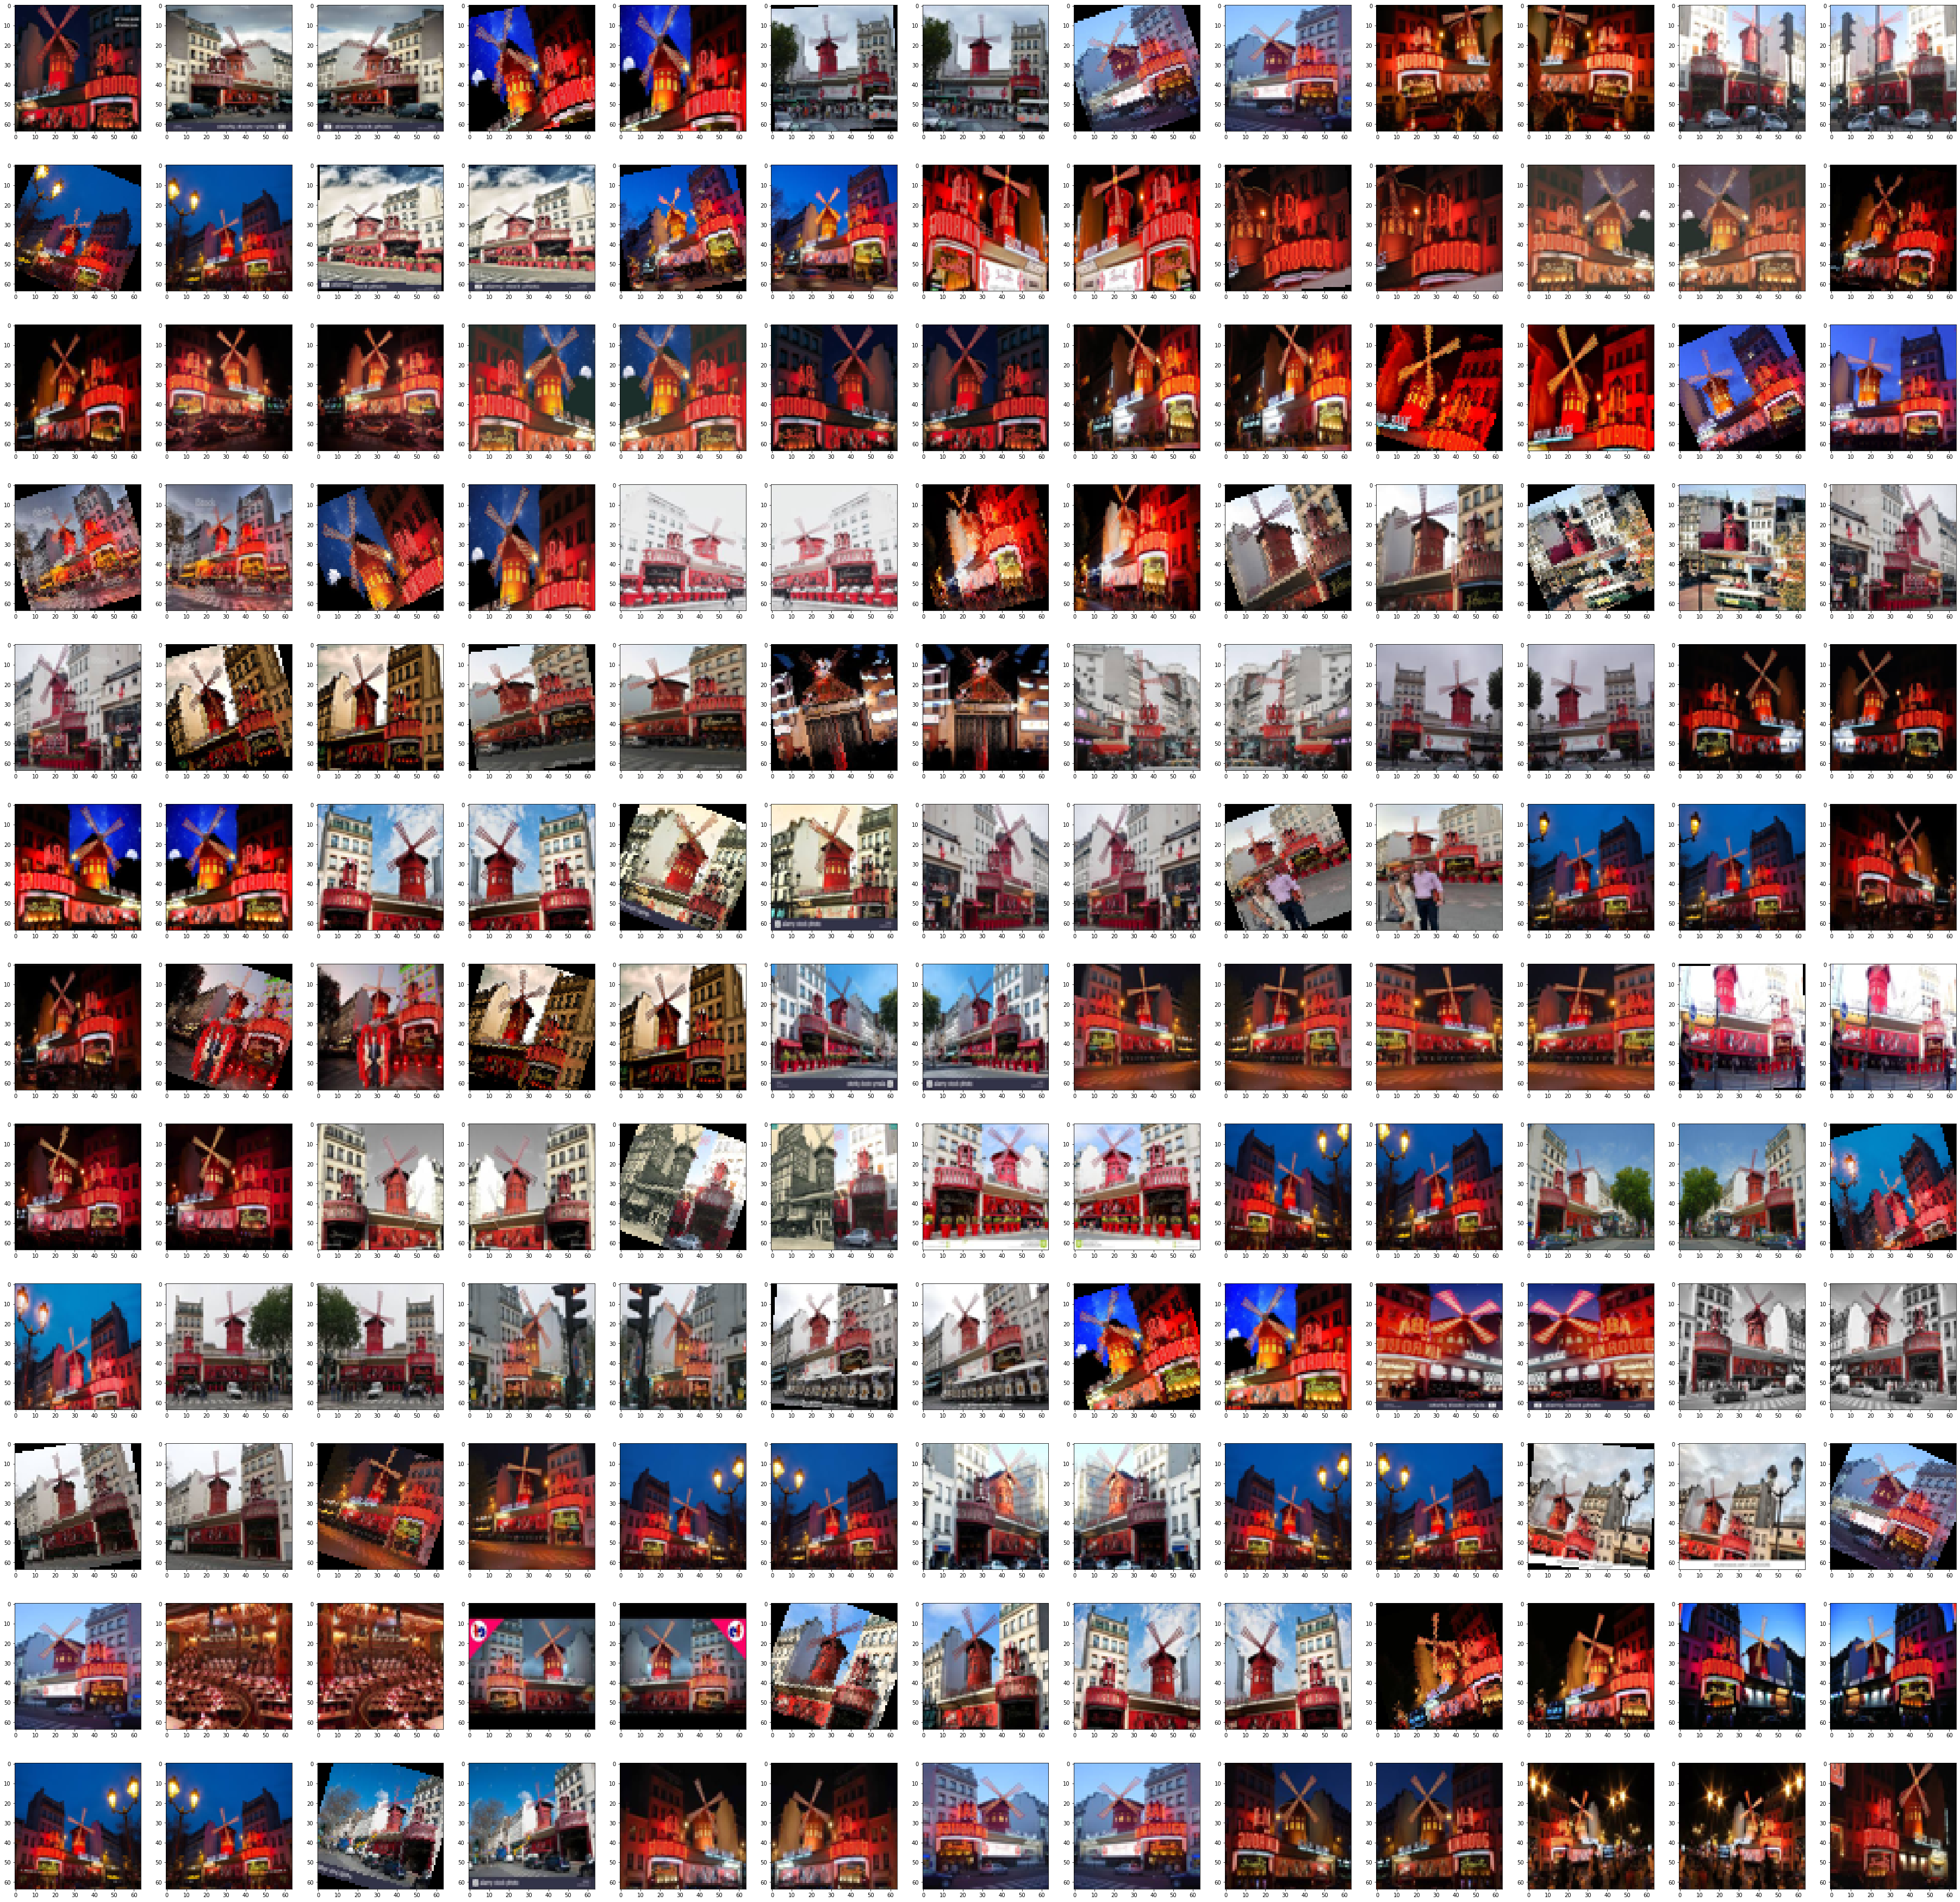

In [13]:
fig = plt.figure(figsize=(64, 64))
columns = 13
rows = 12
for i in range(1, columns*rows +1):
    img = X_train[i].reshape((IMG_SIZE[0], IMG_SIZE[1], 3))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

----

In [14]:
for s in ["train", "valid", "test"]:
    if s == "test":
        print(f"Nombre d'images dans le {s} set:")
        print(f"{len(os.listdir(os.path.join(PATH, s)))} images.")
    else:
        print(f"Nombre d'images par classes dans le {s} set:")
        res = 0
        for cl in classes:
            print(f"- {cl}: {len(os.listdir(os.path.join(PATH, s, cl)))} images.")
            res+=len(os.listdir(os.path.join(PATH, s, cl)))
        print("Total :", res, "images.")
        print()

Nombre d'images par classes dans le train set:
- moulin-rouge: 391 images.
- palais-de-l-elysee: 441 images.
- pont-neuf: 487 images.
- place-de-la-concorde: 457 images.
- jardin-des-tuileries: 393 images.
- hotel-de-ville: 359 images.
- arc-de-triomphe: 471 images.
- musee-d-orsay: 418 images.
Total : 3417 images.

Nombre d'images par classes dans le valid set:
- moulin-rouge: 129 images.
- palais-de-l-elysee: 129 images.
- pont-neuf: 129 images.
- place-de-la-concorde: 129 images.
- jardin-des-tuileries: 129 images.
- hotel-de-ville: 129 images.
- arc-de-triomphe: 129 images.
- musee-d-orsay: 129 images.
Total : 1032 images.

Nombre d'images dans le test set:
1041 images.


928


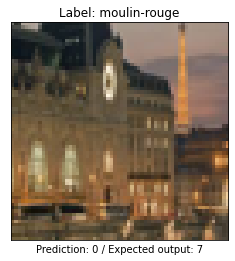

In [15]:
picture_test = np.random.randint(0, len(X_valid)-1)
print(picture_test)
showImg(X_valid[picture_test], y_valid[picture_test], [0, 0, 0]);

## b) Appliquer le modéle linéaire au dataset

Cette section est incomplète.

In [16]:
input_dim = len(X_train[0])

In [17]:
p_model = create_linear_model(input_dim)

In [18]:
picture_test_linear = np.random.randint(0, len(X_train))
test_before = predict_linear_model_classif(p_model, input_dim, X_train[picture_test_linear])
print("Before training:", test_before)

Before training: 1.0


In [19]:
train_linear_classification_model(p_model, input_dim, X_train, y_train.flatten())

In [20]:
test_after = predict_linear_model_classif(p_model, input_dim, X_train[picture_test])
print("After training:", test_after)

After training: -1.0


In [21]:
destroy_linear_model(p_model)

---

## c) Appliquer le PMC au dataset

Nous allons créer un petit modéle contenant une seule couche cachée puis nous allons l'entraîner pour voir s'il sera capable de prédire correctement une image de la Place de la Concorde, notre image test.

In [22]:
NUM_CLASSES = len(classes)
picture_test = 411
input_dim = [len(X_train[0]), 32, NUM_CLASSES]

In [23]:
p_model, len_output_layer = create_mlp_model(input_dim)

In [24]:
def accuracy(model):
    """
    Evalue notre modèle sur les données d'entrainement et de validation.
    """
    true_preds = 0
    total_preds = len(X_train)
    for x, y in zip(X_train, y_train):
        if np.argmax(predict_mlp_model_classification(model, x, NUM_CLASSES)) == np.argmax(y):
            true_preds += 1
    print(f"Accuracy training: {round((true_preds / total_preds) * 100, 2)}%")
    
    true_preds = 0
    total_preds = len(X_valid)
    for x, y in zip(X_valid, y_valid):
        if np.argmax(predict_mlp_model_classification(model, x, NUM_CLASSES)) == np.argmax(y):
            true_preds += 1
    print(f"Accuracy valid: {round((true_preds / total_preds) * 100, 2)}%")

Voyons si notre modéle non entrainé arrive à prédire correctement une image aléatoire du valid set. 

Prediction: [0.99979216, -1.0, -0.39404517, 0.93248546, -0.98820984, 0.85528535, -0.99987984, 0.9986201]


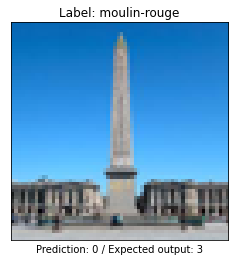

In [25]:
test_before = predict_mlp_model_classification(p_model, X_valid[picture_test], input_dim[-1])

showImg(X_valid[picture_test], y_valid[picture_test], test_before);

print("Prediction:", test_before)

Nous pouvons voir que notre modéle prédit correctement le monument environ 1 fois sur 8 (soit 12.5%). Nous avons 8 classes de monuments, ce qui veut dire que nos résultats sont totalement normaux, car notre modèle n'est pas encore entrainé.

In [26]:
accuracy(p_model)

Accuracy training: 12.38%
Accuracy valid: 12.11%


Entraînons désormais notre modéle. Par soucis de temps, nous allons entraîner manuellement un petit modéle de 1000 époques et puis nous chargerons un gros modéle déjà entraîné par nos soins.

In [27]:
train_classification_stochastic_gradient_backpropagation_mlp_model(p_model, X_train, y_train.flatten(), epochs=1000)#, alpha=0.01)

Voyons si notre modéle entrainé arrive à prédire correctement une image aléatoire du valid set. 

Prediction: [0.99936664, -1.0, 0.49061295, 0.98583263, -0.8161008, 0.4565146, -0.9994749, 0.9983403]


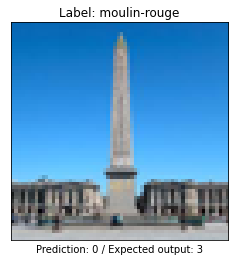

In [28]:
test_after = predict_mlp_model_classification(p_model, X_valid[picture_test], input_dim[-1])

showImg(X_valid[picture_test], y_valid[picture_test], test_after);

print("Prediction:", test_after)

Prédiction **correcte** : Etait-ce un coup de chance ou notre modéle réussit désormais à distinguer les différents monuments ? 

Prédiction **incorrecte** : Notre modéle n'as pas réussi à prédire notre image test, as-t-il réellement appris quelque chose durant sa phase d'entraînement ? Notre modéle est potentiellement entrain de **sous-apprendre**.


Pour en avoir le coeur net, voyons comment il s'en sort face à toutes les données du train et du valid set. Nous aurons un meilleur point de vue de son avancé.

In [29]:
accuracy(p_model)
destroy_mlp_model(p_model)

Accuracy training: 12.8%
Accuracy valid: 11.72%


Prédiction **correcte** : ^^ C'était un coup de chance, pas de bol. Le pourcentage est beaucoup trop faible, notre modéle prédit toujours l'équivalent d'une chance sur 8.

Prédiction **incorrecte** : C'est tout à fait normal, notre modéle n'a pas était assez entraîné.

Passons à la partie intéressante, nous allons charger un modéle pré-entrainé et nous allons effectuer le même test.

Pour commencer, nous allons devoir ré-importer une nouvelle fois les données mais avec une taille d'image différente, nous allons cette fois utiliser des images plus petites (8x8).

In [30]:
IMG_SIZE = (8, 8)

In [31]:
(X_train, y_train), (X_valid, y_valid) = import_dataset(IMG_SIZE)

Assurons-nous que les images soit à la bonne dimension.

In [32]:
print("Dimensions des images applatis :", X_train[0].shape)
print("Dimensions souhaités :", (IMG_SIZE[0]*IMG_SIZE[1]*3,))

Dimensions des images applatis : (192,)
Dimensions souhaités : (192,)


Le prochain modéle que nous allons chargé à était entrainé 10 millions d'époques et ne contient aucune couche cachée.

In [33]:
p_model2 = load_mlp_model("models/mlp/MLP_10000000_8x8_8_t_acc-65.5_v_acc-58.04.txt")

Est-ce que le modéle entrainé 10 millions d'époques sera capable de prédire notre image selectionné aléatoirement. La suite à la prochaine cellule!

Prediction: [-0.17864059, -0.009236684, -0.1145136, 0.8318115, 0.11925446, 0.108996004, 0.16947888, -0.2370879]


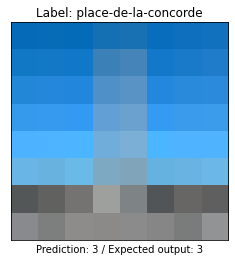

In [34]:
test_load = predict_mlp_model_classification(p_model2, X_valid[picture_test], input_dim[-1])

showImg(X_valid[picture_test], y_valid[picture_test], test_load);

print("Prediction:", test_load)

Prédiction **correcte** : FIIIOUUU ! On a pas travaillé 3 mois pour rien ;)

Prédiction **incorrecte** : Voyons sur toutes les données comment notre modéle réagit. (3 mois à la poubelle )-: )

In [35]:
accuracy(p_model2)
destroy_mlp_model(p_model2)

Accuracy training: 65.5%
Accuracy valid: 58.04%


On peut voir que notre modéle pré-entrainé à un peu plus de 1 chance sur 2 de prédire correctement le monument parisien sur des images qu'il n'a jamais vu.

On aurait de meilleures prédictions si nous avons un modéle soit plus gros, soit plus entrainé. Essayons.

Le prochain modéle que nous allons chargé à était entrainé 15 millions d'époques et ne contient 3 couches cachées (16, 8, 8).

In [36]:
p_model3 = load_mlp_model("models/mlp/overfit/MLP_15000000_16x16_16_8_8_8_t_acc-80.6_v_acc-57.27.txt")

Est-ce que le modéle entrainé 15 millions d'époques sera capable de prédire notre image selectionné aléatoirement. La suite à la prochaine cellule!

Prediction: [-0.0024767136, 0.014698193, 0.018071294, 0.90510345, 0.021234252, 0.0041215764, 0.008198208, -0.008077058]


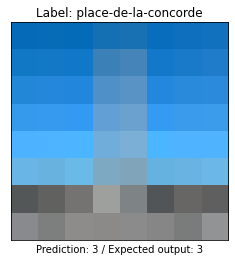

In [37]:
test_p3 = predict_mlp_model_classification(p_model3, X_valid[picture_test], input_dim[-1])

showImg(X_valid[picture_test], y_valid[picture_test], test_p3);

print("Prediction:", test_p3)

Réponse logique, oui. Maintenant, voyons sur toutes les données.

In [38]:
accuracy(p_model3)
destroy_mlp_model(p_model3)

Accuracy training: 79.16%
Accuracy valid: 62.79%


Aïe, notre modéle a sur-appris. :(

----

## d) Découverte de nouveaux modéles

Pour faciliter notre recherche d'architectures, nous avons décidé de créer un équivalent au **GridSearch** de Sklearn. 

In [39]:
import random

On insére les hyperparametres que l'on souhaite essayer sur notre modéle à la prochaine cellule.

In [40]:
number_of_hidden_layers = [3, 4, 5]
hidden_layers = [32, 64, 128]
size_img = [(8, 8), (16, 16)]
EPOCHS = [100]
alphas = [1e-2, 1e-3]

In [41]:
def accuracy_for_grid_search(model, len_output, X_tr, y_tr, X_val, y_val):
    """
    Evalue notre modéle sur les données d'entrainement et de validation.
    """
    train_total, valid_total = len(X_train), len(X_valid)
    true_preds = 0
    total_preds = len(X_tr)
    for x, y in zip(X_tr, y_tr):
        if np.argmax(predict_mlp_model_classification(model, x, len_output)) == np.argmax(y):
            true_preds += 1
    train_acc = round((true_preds / total_preds) * 100, 2)
    
    true_preds = 0
    total_preds = len(X_val)
    for x, y in zip(X_val, y_val):
        if np.argmax(predict_mlp_model_classification(model, x, len_output)) == np.argmax(y):
            true_preds += 1
    valid_acc = round((true_preds / total_preds) * 100, 2)
    
    return train_acc, valid_acc

Notre fonction `grid_search()` a pour but de trouver le modéle qui a les meilleures résultats de prédictions et de les enregistrer.

In [42]:
def grid_search(epochs=EPOCHS, size_img=size_img, hidden_layers=hidden_layers, number_of_hidden_layers=number_of_hidden_layers):
    """
    Equivalent au Grid Search de Sklearn.
    """
    max_train_acc, max_val_acc = 0.0, 0.0

    for ep in EPOCHS:
        for s in size_img:
            IMG_SIZE = s
            (X_train, y_train), (X_valid, y_valid) = import_dataset(IMG_SIZE=IMG_SIZE, data_aug=True)
            input_dim = [len(X_train[0])]
            for al in alphas:
                for n, num_h in enumerate(number_of_hidden_layers):
                    h = random.choices(hidden_layers, k=num_h)
                    if h:
                        input_dim.extend(random.choices(hidden_layers, k=num_h))
                    input_dim.append(NUM_CLASSES)

                    model, last_output_layer = create_mlp_model(input_dim)
                    
                    for _ in range(ep):
                        train_classification_stochastic_gradient_backpropagation_mlp_model(model, X_train, y_train.flatten(), epochs=len(X_train), alpha=al)

                    train_acc, valid_acc = accuracy_for_grid_search(model, last_output_layer, X_train, y_train, X_valid, y_valid)

                    if input_dim[1:-1] == []:
                        filename = f"models/mlp/MLP_{ep}_{al}_{IMG_SIZE[0]}x{IMG_SIZE[1]}_{input_dim[-1]}_t_acc-{train_acc}_v_acc-{valid_acc}.txt"
                    else:
                        filename = f"models/mlp/MLP_{ep}_{al}_{IMG_SIZE[0]}x{IMG_SIZE[1]}_{'_'.join(map(str, input_dim[1:]))}_t_acc-{train_acc}_v_acc-{valid_acc}.txt"

                    print(f"Params ~ epochs={ep},alpha={al},img_size={IMG_SIZE},input_dim={input_dim[1:]} ~ t_acc: {train_acc}% / v_acc: {valid_acc}%")

                    if train_acc > max_train_acc:
                        max_train_acc = train_acc
                        save_mlp_model(model, filename)
                    if valid_acc > max_val_acc:
                        max_val_acc = valid_acc
                        save_mlp_model(model, filename)

                    destroy_mlp_model(model)

                    input_dim = [len(X_train[0])]

        print(f"Max Train acc: {max_train_acc}% / Max Valid_acc: {max_val_acc}%")

C'est parti, on lance la recherche d'architecture.

In [43]:
#grid_search()

Cette fonction nous a permis d'essayer toutes les possibilités des **hyperparametres** de manière automatisé, de pouvoir entraîner plusieurs **modèles** toute une nuit et d'obtenir une sorte de recap à la fin du grid search.

Nous avons essayer tout un panel de taille d'image allant de 6x6 à 64x64, un nombre de couches cachées allant de 0 à 4, des nombres de noeuds par couche entre 4 et 1024 et enfin un nombre d'époques de 1000 allant jusqu'à 20M.

Aujourd'hui, à notre grande surprise, nous avons découvert que pour notre problématique, les modéles sans couches cachées et avec une petite taille d'images prédisent mieux que de **grand/gros** modéles avec une grande taille d'images. 

En plus de leur taille, les grand modéles prennent plus de temps à s'entraîner.

Nos modéles qui généralisent le mieux ont un taux de réussite d'environ 65% de précision sur des données inconnues.

## e) Les courbes d'apprentissage

In [44]:
class LearningPlot:
    def __init__(self, model_name):
        self.model_name = model_name
        
    def display(self, **params):
        if self.model_name.lower() == "mlp":
            input_dim = params.get("input_dim")
            epochs = params.get("epochs")
            alpha = params.get("alpha")
            size_img = params.get("size_img")
            self.display_mlp_curves(size_img, input_dim, epochs, alpha)
        elif self.model_name.lower() == "rbf":
            input_dim = params.get("input_dim")
            epochs = params.get("epochs")
            num_classes = params.get("num_classes")
            k = params.get("k")
            self.display_rbf_curves(input_dim, num_classes, k, epochs)
        else:
            print(f"Le modèle {self.model_name} n'existe pas !")
            raise ArgumentError
            
    
    def display_rbf_curves(self, input_dim, num_classes, k, epochs):
        # TODO : NOT WORKING YET
        losses, val_losses, accs, val_accs = [], [], [], []
        
        model = create_rbfn_model(input_dim, num_classes, k)

        for ep in range(epochs):
            train_rbfn_model(model, X_train, y_train.flatten())

            y_preds = []
            y_true = []
            y_true_l = []
            y_preds_l = []

            for x, y in zip(X_train, y_train):
                preds = predict_rbfn(model, x)
                y_preds_l.append(preds)
                y_preds.append(np.argmax(preds))
                y_true_l.append(y)
                y_true.append(np.argmax(y))
            loss = CategoricalCrossentropy()
            losses.append(loss(y_true_l, y_preds_l))    
            accs.append(accuracy_score(y_true, y_preds))

            y_preds = []
            y_true = []
            y_true_l = []
            y_preds_l = []

            for x, y in zip(X_valid, y_valid):
                preds = predict_rbfn(model, x)
                y_preds_l.append(preds)
                y_preds.append(np.argmax(preds))
                y_true_l.append(y)
                y_true.append(np.argmax(y))
            val_losses.append(loss(y_true_l, y_preds_l))    
            val_accs.append(accuracy_score(y_true, y_preds))

            clear_output(True)

            plt.plot(losses)
            plt.plot(val_losses)
            plt.legend(['loss', 'val_loss'], loc='upper left')
            plt.title('Evolution of loss (CCE)')
            plt.xlabel('epochs')
            plt.ylabel(f'categorical cross-entropy (softmax loss)')
            plt.show() 

            plt.plot(accs)
            plt.plot(val_accs)
            plt.legend(['acc', 'val_acc'], loc='upper left')
            plt.title('Evolution of accuracy')
            plt.xlabel('epochs')
            plt.ylabel(f'Accuracy (%)')
            plt.show()
        
    
    def display_mlp_curves(self, size_img, input_dim, epochs, alpha):
        losses, val_losses, accs, val_accs = [], [], [], []
        model, last_output_layer = create_mlp_model(input_dim)
        
        (X_train, y_train), (X_valid, y_valid) = import_dataset(IMG_SIZE=size_img, data_aug=True)

        for ep in range(epochs):
            train_classification_stochastic_gradient_backpropagation_mlp_model(model, X_train, y_train.flatten(), epochs=len(X_train))

            y_preds = []
            y_true = []
            y_true_l = []
            y_preds_l = []

            for x, y in zip(X_train, y_train):
                preds = predict_mlp_model_classification(model, x, input_dim[-1])
                y_preds_l.append(preds)
                y_preds.append(np.argmax(preds))
                y_true_l.append(y)
                y_true.append(np.argmax(y))
            loss = CategoricalCrossentropy()
            losses.append(loss(y_true_l, y_preds_l))    
            accs.append(accuracy_score(y_true, y_preds))

            y_preds = []
            y_true = []
            y_true_l = []
            y_preds_l = []

            for x, y in zip(X_valid, y_valid):
                preds = predict_mlp_model_classification(model, x, input_dim[-1])
                y_preds_l.append(preds)
                y_preds.append(np.argmax(preds))
                y_true_l.append(y)
                y_true.append(np.argmax(y))
            val_losses.append(loss(y_true_l, y_preds_l))    
            val_accs.append(accuracy_score(y_true, y_preds))
            

            clear_output(True)
            
            print(f"MLP - {input_dim} - {epochs} ep. - {alpha} lr.")
            
            plt.plot(losses)
            plt.plot(val_losses)
            plt.legend(['loss', 'val_loss'], loc='upper left')
            plt.title('Evolution of loss (CCE)')
            plt.xlabel('epochs')
            plt.ylabel(f'categorical cross-entropy (softmax loss)')
            plt.show() 

            plt.plot(accs)
            plt.plot(val_accs)
            plt.legend(['acc', 'val_acc'], loc='upper left')
            plt.title('Evolution of accuracy')
            plt.xlabel('epochs')
            plt.ylabel(f'Accuracy (%)')
            plt.show()

MLP - [192, 128, 32, 64, 8] - 1000 ep. - 0.01 lr.


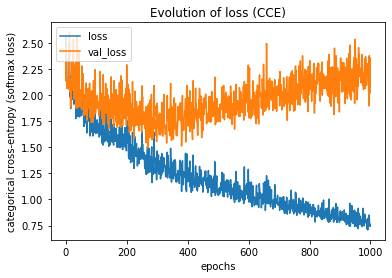

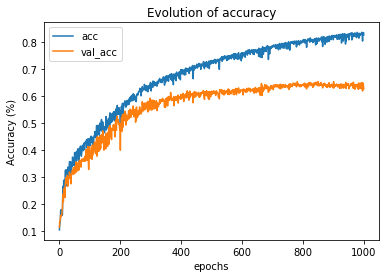

In [45]:
m = LearningPlot("MLP")

IMG_SIZE=(8, 8)

m.display(size_img=IMG_SIZE, input_dim=[IMG_SIZE[0]*IMG_SIZE[1]*3, 128, 32, 64, NUM_CLASSES], epochs=1000, alpha=0.01)

---

# Partie 2. Cas de tests

Avant de démarrer notre recherche d'architecture viable pour nos modèles, il a fallu s'assurer que les algorithmes de notre lib étaient corrects. Pour cela, nous avons utilisé des jeux de données où les résultats sont visuellement interprétables, ou bien dont les prédictions peuvent être calculées à la main sans y passer 4heures. L'idéal était donc de travailler sur des points en 2D ou 3D, avec une quantité limitée de point. Si nos modèles permettent de classifier nos points correctement, on pourra ensuite passer à de plus gros volumes de données, dans des dimensions impossible à interpréter pour l'Humain.

## Classification

### Linear Simple :
        Linear Model : OK
        MLP (2, 1)   : OK

In [ ]:
X = np.array([
      [2.5, 4],
      [2, 3],
      [3, 3]
])
Y = np.array([
      1,
      -1,
      -1
])

In [ ]:
plt.scatter(X[0, 0], X[0, 1], color='blue')
plt.scatter(X[1:3,0], X[1:3,1], color='red')
plt.show()
plt.clf()

In [ ]:
model_dim = len(X[0])

errors = 0

for _ in range(50):
    test_after = []
    p_model = create_linear_model(model_dim)

    train_linear_classification_model(p_model, model_dim, X, Y, alpha=0.001, epochs=10_000)

    for data, expected in zip(X, Y):
        out = predict_linear_model_classif(p_model, model_dim, data)
        test_after.append(out)
        if out != expected:
            errors += 1
    print(test_after)
    destroy_linear_model(p_model)

print(f"errors: {errors}")

### Linear model (simple)

In [ ]:
input_dim = len(X[0])

p_model = create_linear_model(input_dim)
test_before = predict_linear_model_classif(p_model, input_dim, [1, 1])

print("Before training:", test_before)

train_linear_classification_model(p_model, input_dim, X, Y, alpha=0.001, epochs=10000)


test_after = predict_linear_model_classif(p_model, input_dim , [1, 1])

print("After training:",test_after)

### Linear model (advanced)

In [ ]:
model = create_linear_model(input_dim)
test_dataset = [[x1, x2] for x1 in np.arange(-1, 5, 0.5) for x2 in np.arange(-1, 5, 0.5)]
colors = ["blue" if output >= 0 else "red" for output in Y]

predicted_outputs = [predict_linear_model_classif(model, input_dim,  p) for p in test_dataset]
predicted_outputs_colors = ['blue' if label == 1 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()

flattened_dataset_inputs = []
for p in X:
    flattened_dataset_inputs.append(p[0])
    flattened_dataset_inputs.append(p[1])

train_linear_classification_model(model, input_dim, flattened_dataset_inputs, Y, epochs=10000)


predicted_outputs = [predict_linear_model_classif(model,input_dim,  p)  for p in test_dataset]
predicted_outputs_colors = ['blue' if label == 1 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()

test_after = predict_linear_model_classif(p_model, input_dim, [1, 1])

print("Prediction after training of [1, 1], the prediction need to be equal to 1. \nPrediction:", test_after)

flattened_dataset_inputs = []
for p in X:
    flattened_dataset_inputs.append(p[0])
    flattened_dataset_inputs.append(p[1])

destroy_linear_model(model)

### MLP (simple)

In [ ]:
input_dim = [len(X[0]), 1]

p_model, _= create_mlp_model(input_dim)
test_before = predict_mlp_model_classification(p_model, [1, 1])

print("Before training:", test_before)

train_classification_stochastic_gradient_backpropagation_mlp_model(p_model, X, Y)

test_after = predict_mlp_model_classification(p_model, [1, 1])

print("After training:", test_after)

### MLP (advanced)

In [ ]:
model, _ = create_mlp_model(input_dim)
test_dataset = [[x1, x2] for x1 in np.arange(-1, 5, 0.5) for x2 in np.arange(-1, 5, 0.5)]
colors = ["blue" if output >= 0 else "red" for output in Y]

predicted_outputs = [predict_mlp_model_classification(model,  p)  for p in test_dataset]
predicted_outputs_colors = ['blue' if label[0] >= 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()

flattened_dataset_inputs = []
for p in X:
    flattened_dataset_inputs.append(p[0])
    flattened_dataset_inputs.append(p[1])

train_classification_stochastic_gradient_backpropagation_mlp_model(model, X, Y)

predicted_outputs = [predict_mlp_model_classification(model,  p)  for p in test_dataset]
predicted_outputs_colors = ['blue' if label[0] >= 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()

test_after = predict_mlp_model_classification(p_model , [1, 1])

print("Prediction after training of [1, 1], the result need to be equal to 1. Result:", test_after)

flattened_dataset_inputs = []
for p in X:
    flattened_dataset_inputs.append(p[0])
    flattened_dataset_inputs.append(p[1])

destroy_mlp_model(model)

### RBFN

In [ ]:
num_classes = 2
k = 2
input_dim = 2
expected_output = [[1,0] if label >= 0 else [0,1] for label in Y]
model = create_rbfn_model(input_dim, num_classes, k)
train_rbfn_model(model, X, expected_output)

colors = ['blue' if coord >= 0 else 'red' for coord in Y]
plot_input = [[x,y] for x in range(6) for y in range(6)]
plot_output_colors = ['blue' if predict[0] > predict[1] else 'red' for predict in [predict_rbfn(model, coord) for coord in plot_input]]
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.scatter([p[0] for p in plot_input], [p[1] for p in plot_input], c=plot_output_colors)
plt.show()

### Linear Multiple :
        Linear Model : OK
        MLP (2, 1)   : OK

In [ ]:
X = np.concatenate([np.random.random((50,2)) * 0.9 + np.array([1, 1]), np.random.random((50,2)) * 0.9 + np.array([2, 2])])
Y = np.concatenate([np.ones((50, 1)), np.ones((50, 1)) * -1.0])
plt.scatter(X[0:50, 0], X[0:50, 1], color='blue')
plt.scatter(X[50:100,0], X[50:100,1], color='red')
plt.show()
plt.clf()

### Linear model (simple)

In [ ]:
input_dim = len(X[0])

p_model = create_linear_model(input_dim)
test_before = predict_linear_model_classif(p_model, input_dim, [1.25, 1.25])

print("Before training:", test_before)

train_linear_classification_model(p_model, input_dim, X, Y)


test_after = predict_linear_model_classif(p_model, input_dim , [1.25, 1.25])

print("After training:",test_after)

### Linear model (advanced)

In [ ]:
model = create_linear_model(input_dim)
test_dataset = [[x1, x2] for x1 in np.arange(1, 3, 0.1) for x2 in np.arange(1, 3, 0.1)]
colors = ["blue" if output >= 0 else "red" for output in Y]

predicted_outputs = [predict_linear_model_classif(model, input_dim,  p)  for p in test_dataset]
predicted_outputs_colors = ['blue' if label == 1 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()

flattened_dataset_inputs = []
for p in X:
    flattened_dataset_inputs.append(p[0])
    flattened_dataset_inputs.append(p[1])
    #print(flattened_dataset_inputs)

train_linear_classification_model(model, input_dim, X, Y, epochs=100000)

predicted_outputs = [predict_linear_model_classif(model,input_dim,  p)  for p in test_dataset]
predicted_outputs_colors = ['blue' if label == 1 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()

test_after = predict_linear_model_classif(p_model, input_dim , [2.5, 2.5])

print("Prediction:", test_after)

flattened_dataset_inputs = []
for p in X:
    flattened_dataset_inputs.append(p[0])
    flattened_dataset_inputs.append(p[1])

destroy_linear_model(model)

### MLP (simple)

In [ ]:
input_dim = [len(X[0]), 1]

p_model, _ = create_mlp_model(input_dim)
test_before = predict_mlp_model_classification(p_model, [1.25, 1.25])

print("Before training:", test_before)

train_classification_stochastic_gradient_backpropagation_mlp_model(p_model, X, Y)

test_after = predict_mlp_model_classification(p_model, [1.25, 1.25])

print("After training:", test_after)

### MLP (advanced)

In [ ]:
model, _= create_mlp_model(input_dim)
test_dataset = [[x1, x2] for x1 in np.arange(1, 3, 0.1) for x2 in np.arange(1, 3, 0.1)]
colors = ["blue" if output >= 0 else "red" for output in Y]

predicted_outputs = [predict_mlp_model_classification(model,  p)  for p in test_dataset]
predicted_outputs_colors = ['blue' if label[0] >= 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()

flattened_dataset_inputs = []
for p in X:
    flattened_dataset_inputs.append(p[0])
    flattened_dataset_inputs.append(p[1])

train_classification_stochastic_gradient_backpropagation_mlp_model(model, X, Y, epochs=100000)

predicted_outputs = [predict_mlp_model_classification(model,  p)  for p in test_dataset]
predicted_outputs_colors = ['blue' if label[0] >= 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()

test_after = predict_mlp_model_classification(p_model , [1, 1])

print("Prediction:", test_after)

flattened_dataset_inputs = []
for p in X:
    flattened_dataset_inputs.append(p[0])
    flattened_dataset_inputs.append(p[1])

destroy_mlp_model(model)

### RBFN

In [ ]:
num_classes = 2
k = 20
input_dim = 2
expected_output = [[1,0] if label >= 0 else [0,1] for label in Y]
model = create_rbfn_model(input_dim, num_classes, k)
train_rbfn_model(model, X, expected_output)

colors = ['blue' if coord >= 0 else 'red' for coord in Y]
plot_input = [[x/10,y/10] for x in range(51) for y in range(51)]
plot_output_colors = ['blue' if predict[0] > predict[1] else 'red' for predict in [predict_rbfn(model, coord) for coord in plot_input]]
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.scatter([p[0] for p in plot_input], [p[1] for p in plot_input], c=plot_output_colors)
plt.show()

### XOR :
        Linear Model    : KO
        MLP (2, 2, 1)   : OK

In [ ]:
X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]])
Y = np.array([1, 1, -1, -1])

In [ ]:
plt.scatter(X[0:2, 0], X[0:2, 1], color='blue')
plt.scatter(X[2:4,0], X[2:4,1], color='red')
plt.show()
plt.clf()

### Linear model (simple)

On isole les 4 points par 2 sorties de
modèle linéaire, chacune entraînée par 2 valeurs d’une classe et 1 valeur de
l’autre classe. On simule en réalité le travail d’un MLP (2,2,1)

In [ ]:
input_dim = len(X[0])

p_model = create_linear_model(input_dim)
test_before = predict_linear_model_classif(p_model, input_dim , [0, 0])

print("Before training:", test_before)

train_linear_classification_model(p_model, input_dim, X, Y)


test_after = predict_linear_model_classif(p_model, input_dim , [0, 0])

print("After training:",test_after)

### Linear model (advanced)

In [ ]:
X = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
Y = np.array([-1, 1, 1, -1])

In [ ]:
input_dim = len(X[0])

model_top = create_linear_model(input_dim)
model_bottom = create_linear_model(input_dim)


test_dataset = [[x1, x2] for x1 in np.arange(-1, 2, 0.1) for x2 in np.arange(-1, 2, 0.1)]
colors = ["blue" if output >= 0 else "red" for output in Y]

predicted_outputs_top = [predict_linear_model_classif(model_top, input_dim,  p)  for p in test_dataset]
predicted_outputs_bottom = [predict_linear_model_classif(model_bottom, input_dim,  p)  for p in test_dataset]

predicted_outputs_colors = ['blue' if top == 1 and bottom == 1 else 'red' for (top, bottom) in zip(predicted_outputs_top, predicted_outputs_bottom)]

plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()

train_linear_classification_model(model_top, input_dim, X[:-1], Y[:-1], alpha=0.01, epochs=100000)
train_linear_classification_model(model_bottom, input_dim, X[1:], Y[1:], alpha=0.01, epochs=100000)


predicted_outputs_top = [predict_linear_model_classif(model_top, input_dim,  p)  for p in test_dataset]
predicted_outputs_bottom = [predict_linear_model_classif(model_bottom, input_dim,  p)  for p in test_dataset]

predicted_outputs_colors = ['blue' if top == 1 and bottom == 1 else 'red' for (top, bottom) in zip(predicted_outputs_top, predicted_outputs_bottom)]

plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()

destroy_linear_model(model_top)
destroy_linear_model(model_bottom)

### MLP (simple)

In [ ]:
input_dim = [len(X[0]), len(X[0]), 1]

p_model, _= create_mlp_model(input_dim)
test_before = predict_mlp_model_classification(p_model, [1, 1])

print("Before training:", test_before)

train_classification_stochastic_gradient_backpropagation_mlp_model(p_model, X, Y)

test_after = predict_mlp_model_classification(p_model, [1, 1])

print("After training:", test_after)

### MLP (advanced)

In [ ]:
model, _ = create_mlp_model(input_dim)
test_dataset = [[x1, x2] for x1 in np.arange(-1, 2, 0.1) for x2 in np.arange(-1, 2, 0.1)]
colors = ["blue" if output >= 0 else "red" for output in Y]

predicted_outputs = [predict_mlp_model_classification(model,  p)  for p in test_dataset]
predicted_outputs_colors = ['blue' if label[0] >= 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()

flattened_dataset_inputs = []
for p in X:
    flattened_dataset_inputs.append(p[0])
    flattened_dataset_inputs.append(p[1])

train_classification_stochastic_gradient_backpropagation_mlp_model(model, X, Y, epochs=100000)

predicted_outputs = [predict_mlp_model_classification(model,  p)  for p in test_dataset]
predicted_outputs_colors = ['blue' if label[0] >= 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()

test_after = predict_mlp_model_classification(p_model, [1, 1])

destroy_mlp_model(model)

### RBFN

In [ ]:
num_classes = 2
k = 4
input_dim = 2
expected_output = [[1,0] if label >= 0 else [0,1] for label in Y]
modif_input = [[coord[0],coord[1]] for coord in X]
model = create_rbfn_model(input_dim, num_classes, k)
train_rbfn_model(model, X, expected_output, naif=True)

colors = ['blue' if coord >= 0 else 'red' for coord in Y]
plot_input = [[x/5,y/5] for x in range(6) for y in range(6)]
plot_output_colors = ['blue' if predict[0] > predict[1] else 'red' for predict in [predict_rbfn(model, coord) for coord in plot_input]]
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.scatter([p[0] for p in plot_input], [p[1] for p in plot_input], c=plot_output_colors)
plt.show()

### Cross :
        Linear Model    : KO
        MLP (2, 4, 1)   : OK

In [ ]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([1 if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else -1 for p in X])

In [ ]:
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == -1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == -1, enumerate(X)))))[:,1], color='red')
plt.show()
plt.clf()

### Linear model (simple)

On génère plusieurs modèles linéaires
qui vont découper la croix en différentes parties pour isoler 1 à 1 les blocs
rouges

In [ ]:
input_dim = len(X[0])

p_model = create_linear_model(input_dim)
test_before = predict_linear_model_classif(p_model, input_dim , [0, 0])

print("Before training:", test_before)

train_linear_classification_model(p_model, input_dim, X, Y)


test_after = predict_linear_model_classif(p_model, input_dim , [0, 0])

print("After training:",test_after)

### Linear model (advanced)

In [ ]:
input_dim = len(X[0])

model_vl = create_linear_model(input_dim)
model_vr = create_linear_model(input_dim)
model_ht = create_linear_model(input_dim)
model_hb = create_linear_model(input_dim)


test_dataset = [[x1, x2] for x1 in np.arange(-2, 2, 0.1) for x2 in np.arange(-2, 2, 0.1)]
colors = ["blue" if output >= 0 else "red" for output in Y]

predicted_outputs_vl = [predict_linear_model_classif(model_vl, input_dim,  p)  for p in test_dataset]
predicted_outputs_vr = [predict_linear_model_classif(model_vr, input_dim,  p)  for p in test_dataset]
predicted_outputs_ht = [predict_linear_model_classif(model_ht, input_dim,  p)  for p in test_dataset]
predicted_outputs_hb = [predict_linear_model_classif(model_hb, input_dim,  p)  for p in test_dataset]

predicted_outputs_colors = ['blue' if (vl == 1 and vr == 1) or (ht == 1 and hb == 1) else 'red' for (vl, vr, ht, hb) in zip(predicted_outputs_vl, predicted_outputs_vr, predicted_outputs_ht, predicted_outputs_hb)]

plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()


ht = np.array([[x[0],x[1],n] for n,x in enumerate(X) if (x[1] > -0.3 and (x[0] > 0.3 or x[0] < -0.3) ) ])
c = ["blue" if Y[int(n)] == 1 else "red" for n in ht[:, 2]]
plt.scatter(ht[:, 0], ht[:, 1], c=c)
plt.axis([-1, 1, -1, 1])
plt.title("Horizontal top")
plt.show()

vr = np.array([[x[0],x[1], int(n)] for n,x in enumerate(X) if x[0] > -0.3 and (x[1] > 0.3 or x[1] < -0.3) ])
c = ["blue" if Y[int(n)] == 1 else "red" for n in vr[:, 2]]
plt.scatter(vr[:, 0], vr[:, 1], c=c)
plt.axis([-1, 1, -1, 1])
plt.title("Vertical right")
plt.show()

vl = np.array([[x[0],x[1],int(n)] for n,x in enumerate(X) if (x[0] < 0.3 and (x[1] < -0.3 or x[1] > 0.3))])
c = ["blue" if Y[int(n)] == 1 else "red" for n in vl[:, 2]]
plt.scatter(vl[:, 0], vl[:, 1], c=c)
plt.axis([-1, 1, -1, 1])
plt.title("Vertical left")
plt.show()

hb = np.array([[x[0],x[1],int(n)] for n,x in enumerate(X) if (x[1] < 0.3 and (x[0] < -0.3 or x[0] > 0.3))])
c = ["blue" if Y[int(n)] == 1 else "red" for n in hb[:, 2]]
plt.scatter(hb[:, 0], hb[:, 1], c=c)
plt.axis([-1, 1, -1, 1])
plt.title("Horizontal bottom")
plt.show()


# On était bloqué la wola
train_linear_classification_model(model_vl, input_dim, vl[:, :-1], Y[vl[:,-1].astype(int)], epochs=100000)
train_linear_classification_model(model_vr, input_dim, vr[:, :-1], Y[vr[:,-1].astype(int)], epochs=100000)
train_linear_classification_model(model_ht, input_dim, ht[:, :-1], Y[ht[:,-1].astype(int)], epochs=100000)
train_linear_classification_model(model_hb, input_dim, hb[:, :-1], Y[hb[:,-1].astype(int)], epochs=100000)


predicted_outputs_vl = [predict_linear_model_classif(model_vl, input_dim,  p)  for p in test_dataset]
predicted_outputs_vr = [predict_linear_model_classif(model_vr, input_dim,  p)  for p in test_dataset]
predicted_outputs_ht = [predict_linear_model_classif(model_ht, input_dim,  p)  for p in test_dataset]
predicted_outputs_hb = [predict_linear_model_classif(model_hb, input_dim,  p)  for p in test_dataset]

predicted_outputs_colors = ['blue' if (vl == 1 and vr == 1) or (ht == 1 and hb == 1) else 'red' for (vl, vr, ht, hb) in zip(predicted_outputs_vl, predicted_outputs_vr, predicted_outputs_ht, predicted_outputs_hb)]

plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()



destroy_linear_model(model_vl)
destroy_linear_model(model_vr)
destroy_linear_model(model_ht)
destroy_linear_model(model_hb)

### MLP (simple)

In [ ]:
input_dim = [len(X[0]), len(X[0])*2, 1]

p_model, _ = create_mlp_model(input_dim)
test_before = predict_mlp_model_classification(p_model, [0, 0])

print("Before training:", test_before)

train_classification_stochastic_gradient_backpropagation_mlp_model(p_model, X, Y)

test_after = predict_mlp_model_classification(p_model, [0, 0])

print("After training:", test_after)

### MLP (advanced)

In [ ]:
model, _ = create_mlp_model(input_dim)
test_dataset = [[x1, x2] for x1 in np.arange(-2, 2, 0.1) for x2 in np.arange(-2, 2, 0.1)]
colors = ["blue" if output >= 0 else "red" for output in Y]

predicted_outputs = [predict_mlp_model_classification(model,  p)  for p in test_dataset]
predicted_outputs_colors = ['blue' if label[0] >= 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()

flattened_dataset_inputs = []
for p in X:
    flattened_dataset_inputs.append(p[0])
    flattened_dataset_inputs.append(p[1])

train_classification_stochastic_gradient_backpropagation_mlp_model(model, X, Y, alpha=0.01, epochs=200000)

predicted_outputs = [predict_mlp_model_classification(model,  p)  for p in test_dataset]
predicted_outputs_colors = ['blue' if label[0] >= 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()

test_after = predict_mlp_model_classification(p_model , [1, 1])

destroy_mlp_model(model)

### RBFN

In [ ]:
num_classes = 2
k = 30
input_dim = 2
expected_output = [[1,0] if coord >= 0 else [0,1] for coord in Y]
modif_input = [[coord[0],coord[1]] for coord in X]
model = create_rbfn_model(input_dim, num_classes, k)
train_rbfn_model(model, modif_input, expected_output)

colors = ['blue' if coord >= 0 else 'red' for coord in Y]
plot_input = np.random.random((500, 2)) * 2.0 - 1.0
plot_output_colors = ['blue' if predict[0] > predict[1] else 'red' for predict in [predict_rbfn(model, coord) for coord in plot_input]]
#plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.scatter([p[0] for p in plot_input], [p[1] for p in plot_input], c=plot_output_colors)
plt.show()

### Multi Linear 3 classes :
        Linear Model x3 : OK
        MLP (2, 3)      : OK

In [ ]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([[1, 0, 0] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0 else # bleu
              [0, 1, 0] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0 else # rouge
              [0, 0, 1] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0 else # vert
              [0, 0, 0]for p in X])

In [ ]:
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,1], color='red')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,1], color='green')
plt.show()
plt.clf()

### Linear model (simple)

In [ ]:
input_dim = 2

p_model = create_linear_model(input_dim)
test_before = predict_linear_model_classif(p_model, input_dim, [-0.75, -0.50])

print("Before training:", test_before)

flattened_Y = Y[-1].flatten()

train_linear_classification_model(p_model, input_dim, X, flattened_Y)

test_after = predict_linear_model_classif(p_model, input_dim, [-0.75, -0.50])

print("After training:",test_after)

### Linear model (advanced)

In [ ]:
input_dim = len(X[0])


model_dr = create_linear_model(input_dim)
model_dl = create_linear_model(input_dim)
model_h = create_linear_model(input_dim)

test_dataset = [[x1, x2] for x1 in np.arange(-1.5, 1.5, 0.1) for x2 in np.arange(-1.5, 1.5, 0.1)]
colors = ["blue" if output[0] == 1 else ("red" if output[1] == 1 else ("green" if output[2] == 1 else "black")) for output in Y]

dr = np.array([1 if y[2] == 1 else -1 for y in Y])
h = np.array([1 if y[1] == 1 else -1 for y in Y])
dl = np.array([1 if y[0] == 1 else -1 for y in Y])

predicted_outputs_dr = [predict_linear_model_classif(model_dr, input_dim,  p)  for p in test_dataset]
predicted_outputs_dl = [predict_linear_model_classif(model_dl, input_dim,  p)  for p in test_dataset]
predicted_outputs_h = [predict_linear_model_classif(model_h, input_dim,  p)  for p in test_dataset]


predicted_outputs_colors = ['green' if (dr == 1 and dl == -1 and h == -1) else ("blue" if (dl == 1 and dr == -1 and h == -1) else ("red" if (h == 1 and dr == -1 and dl == -1) else "black")) for (dr, dl, h) in zip(predicted_outputs_dr, predicted_outputs_dl, predicted_outputs_h)]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=40)
plt.show()


flattened_dataset_outputs = []
for p in Y:
    flattened_dataset_outputs.append(p[0])
    flattened_dataset_outputs.append(p[1])
    flattened_dataset_outputs.append(p[2])
    

train_linear_classification_model(model_dl, input_dim, X, dl, alpha=0.01, epochs=100000)
train_linear_classification_model(model_dr, input_dim, X, dr, alpha=0.01, epochs=100000)
train_linear_classification_model(model_h, input_dim, X, h, alpha=0.01, epochs=100000)


predicted_outputs_dr = [predict_linear_model_classif(model_dr, input_dim,  p)  for p in test_dataset]
predicted_outputs_dl = [predict_linear_model_classif(model_dl, input_dim,  p)  for p in test_dataset]
predicted_outputs_h = [predict_linear_model_classif(model_h, input_dim,  p)  for p in test_dataset]

predicted_outputs_colors = ['green' if (dr == 1 and dl == -1 and h == -1) else ("blue" if (dl == 1 and dr == -1 and h == -1) else ("red" if (h == 1 and dr == -1 and dl == -1) else "black")) for (dr, dl, h) in zip(predicted_outputs_dr, predicted_outputs_dl, predicted_outputs_h)]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=40)
plt.show()

### MLP (simple)

In [ ]:
input_dim = [len(X[0]), 3]

p_model, len_output_layer = create_mlp_model(input_dim)
test_before = predict_mlp_model_classification(p_model, np.array([-0.75, -0.50]), len_output_layer)

print("Before training:", test_before)

train_classification_stochastic_gradient_backpropagation_mlp_model(p_model, X, Y.flatten())

test_after = predict_mlp_model_classification(p_model, np.array([-0.75, -0.50]), len_output_layer)

print("After training:", test_after)

### MLP (advanced)

In [ ]:
input_dim = [len(X[0]), 3]

model, len_output_layer = create_mlp_model(input_dim)
test_dataset = [[x1, x2] for x1 in np.arange(-1.5, 1.6, 0.2) for x2 in np.arange(-1.5, 1.6, 0.2)]
colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for output in Y]

predicted_outputs = [predict_mlp_model_classification(model, p, len_output_layer)  for p in test_dataset]
predicted_outputs_colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for output in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=50)
plt.show()

train_classification_stochastic_gradient_backpropagation_mlp_model(model, X, Y.flatten())

predicted_outputs = [predict_mlp_model_classification(model, p, len_output_layer)  for p in test_dataset]
predicted_outputs_colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for output in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=50)
plt.show()

flattened_dataset_inputs = []
for p in X:
    flattened_dataset_inputs.append(p[0])
    flattened_dataset_inputs.append(p[1])

destroy_mlp_model(model)

### RBF

In [ ]:
num_classes = 3
k = 30
input_dim = 2
expected_output = Y
modif_input = [[coord[0],coord[1]] for coord in X]
model = create_rbfn_model(input_dim, num_classes, k)
train_rbfn_model(model, modif_input, expected_output)

#colors = ['blue' if coord >= 0 else 'red' for coord in Y]
plot_input = np.random.random((500, 2)) * 2.0 - 1.0
plot_output_colors = ['blue' if predict[0] > predict[1] and predict[0] > predict[2] else ('red' if predict[1] > predict[2] else 'green') for predict in [predict_rbfn(model, coord, 3) for coord in plot_input]]
#plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.scatter([p[0] for p in plot_input], [p[1] for p in plot_input], c=plot_output_colors)
plt.show()

### Multi Cross :
        Linear Model x3 : KO
        MLP (2, ?, ?, 3): OK

In [ ]:
X = np.random.random((1000, 2)) * 2.0 - 1.0
Y = np.array([[1, 0, 0] if abs(p[0] % 0.5) <= 0.25 and abs(p[1] % 0.5) > 0.25 else [0, 1, 0] if abs(p[0] % 0.5) > 0.25 and abs(p[1] % 0.5) <= 0.25 else [0, 0, 1] for p in X])

In [ ]:
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,1], color='red')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,1], color='green')
plt.show()
plt.clf()

### Linear model (simple)

Impossible de classer tous ces groupes
avec uniquement 3 “droites”, on a alors transformé les entrées de notre
modèle pour n’avoir qu’une instance des quatre groupes qui se répétaient à
l’infini sur l’ensemble d’origine.

In [ ]:
"""
input_dim = len(X[0])

p_model = create_linear_model(input_dim)
test_before = predict_linear_model_classif(p_model, input_dim , [2, 2])

print("Before training:", test_before)

flattened_X = X.flatten()

train_linear_classification_model(p_model, input_dim, flattened_X, Y)

test_after = predict_linear_model_classif(p_model, input_dim , [2, 2])

print("After training:",test_after)
"""

### Linear model (advanced)

Ne fonctionne pas

In [ ]:
"""
model = create_linear_model(input_dim)
test_dataset = [[x1, x2] for x1 in range(1, 2) for x2 in range(1, 2)]
colors = ["blue" if output >= 0 else "red" for output in Y]

predicted_outputs = [predict_linear_model_classif(model, input_dim,  p)  for p in test_dataset]
predicted_outputs_colors = ['blue' if label == 1 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()

flattened_dataset_inputs = []
for p in X:
    flattened_dataset_inputs.append(p[0])
    flattened_dataset_inputs.append(p[1])

train_linear_classification_model(model, input_dim, flattened_dataset_inputs, Y)

predicted_outputs = [predict_linear_model_classif(model,input_dim,  p)  for p in test_dataset]
predicted_outputs_colors = ['blue' if label == 1 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()

test_after = predict_linear_model_classif(p_model, input_dim , [1.25, 1.25])

print("Prediction:", test_after)

flattened_dataset_inputs = []
for p in X:
    flattened_dataset_inputs.append(p[0])
    flattened_dataset_inputs.append(p[1])

destroy_linear_model(model)
"""

### MLP (simple)

Nous avons cherché à augmenter le nombre de
neurones par couche jusqu’à ne plus observer qu’une stagnation des
performances de traitement contre un temps de traitement croissant. On a
considéré qu’une forme de (2,64,64,3) était un bon compromis
performances/rapidité. Il a cependant fallu travailler sur le nombre
d'époques ainsi que sur la correction apportée à chaque époque pour
favoriser l'entraînement

In [ ]:
input_dim = [len(X[0]),2,2,3]

p_model, len_output_layer = create_mlp_model(input_dim)
test_before = predict_mlp_model_classification(p_model, [2.5, 2.5], len_output_layer)

print("Before training:", test_before)

train_classification_stochastic_gradient_backpropagation_mlp_model(p_model, X, Y.flatten(), epochs=10000)

test_after = predict_mlp_model_classification(p_model, [2.5, 2.5], len_output_layer)

print("After training:", test_after)

### MLP (advanced)

In [ ]:
input_dim = [len(X[0]),26,26,3]


model, len_output_layer = create_mlp_model(input_dim)
test_dataset = [[x1, x2] for x1 in np.arange(-2, 2,0.1) for x2 in np.arange(-2, 2, 0.1)]
colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for output in Y]

predicted_outputs = [predict_mlp_model_classification(model, p, len_output_layer)  for p in test_dataset]
predicted_outputs_colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for output in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=100)
plt.show()


train_classification_stochastic_gradient_backpropagation_mlp_model(model, X, Y.flatten(), alpha=0.03, epochs=1000000)

predicted_outputs = [predict_mlp_model_classification(model, p, len_output_layer)  for p in test_dataset]
predicted_outputs_colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for output in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
#plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=100)
plt.show()


destroy_mlp_model(model)

### RBF

In [ ]:
num_classes = 3
k = 100
input_dim = 2
expected_output = Y
modif_input = [[coord[0],coord[1]] for coord in X]
model = create_rbfn_model(input_dim, num_classes, k)
train_rbfn_model(model, modif_input, expected_output)

#colors = ['blue' if coord >= 0 else 'red' for coord in Y]
plot_input = np.random.random((1000, 2)) * 2.0 - 1.0
plot_output_colors = ['blue' if predict[0] > predict[1] and predict[0] > predict[2] else ('red' if predict[1] > predict[2] else 'green') for predict in [predict_rbfn(model, coord, 3) for coord in plot_input]]
#plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.scatter([p[0] for p in plot_input], [p[1] for p in plot_input], c=plot_output_colors)
plt.show()

## Régression

### Linear Simple 2D :
        Linear Model : OK
        MLP (1, 1)   : OK

In [ ]:
X = np.array([
      [1],
      [2]
])
Y = np.array([
      2,
      3
])

In [ ]:
plt.scatter(X,Y)
plt.show()
plt.clf()

### Linear model (simple)

In [ ]:
input_dim = len(X[0])

model = create_linear_model(input_dim)

flattened_dataset_inputs = np.array(X).flatten()

test_before = predict_linear_model_regression(model, input_dim, [3])

train_linear_regression_model(model, input_dim, flattened_dataset_inputs, Y)

test_after = predict_linear_model_regression(model, input_dim, [3])

print("before:", test_before)
print("after:", test_after)

destroy_linear_model(model)

### Linear model (advanced)

In [ ]:
input_dim = len(X[0])

model = create_linear_model(input_dim)
flattened_dataset_inputs = []
for p in X:
    flattened_dataset_inputs.append(p[0])

test_dataset_inputs = [i for i in range(0, 6)]
predicted_outputs = [predict_linear_model_regression(model, input_dim, [p])  for p in test_dataset_inputs]

plt.plot(test_dataset_inputs, predicted_outputs)
plt.scatter([p[0] for p in X], Y, s=200)
plt.axis([0, 5, 0, 5])
plt.show()

train_linear_regression_model(model, input_dim, flattened_dataset_inputs, Y)

test_dataset_inputs = [i for i in range(0, 6)]
predicted_outputs = [predict_linear_model_regression(model, input_dim, [p])  for p in test_dataset_inputs]

plt.plot(test_dataset_inputs, predicted_outputs)
plt.scatter([p[0] for p in X], Y, s=200)
plt.axis([0, 5, 0, 5])
plt.show()

destroy_linear_model(model)

### MLP (simple)

In [ ]:
model, _ = create_mlp_model([1, 1])    

test_before = predict_mlp_model_regression(model, [3])[0]

train_regression_stochastic_gradient_backpropagation_mlp_model(model, 
                                                               X, 
                                                               Y)

test_after = predict_mlp_model_regression(model, [3])[0]

print("before:", test_before)
print("after:", test_after)

destroy_mlp_model(model)

### MLP (advanced)

In [ ]:
model, _ = create_mlp_model([1, 1])    

test_dataset_inputs = [i for i in range(-10, 11)]
predicted_outputs = [predict_mlp_model_regression(model, [p])[0]  for p in test_dataset_inputs]

plt.plot(test_dataset_inputs, predicted_outputs)
plt.scatter([p[0] for p in X], Y, s=200)
plt.axis([-10, 10, -10, 10])
plt.show()

train_regression_stochastic_gradient_backpropagation_mlp_model(model, 
                                                               X, 
                                                               Y)

test_dataset_inputs = [i for i in range(-10, 11)]
predicted_outputs = [predict_mlp_model_regression(model, [p])[0]  for p in test_dataset_inputs]

plt.plot(test_dataset_inputs, predicted_outputs)
plt.scatter([p[0] for p in X], Y, s=200)
plt.axis([-10, 10, -10, 10])
plt.show()

### RBF

In [ ]:
num_classes = 1
k = 2
input_dim = 1
expected_output = Y
modif_input = X
model = create_rbfn_model(input_dim, num_classes, k)
train_rbfn_model(model, modif_input, expected_output, True)

plot_input = np.random.random((100, 1)) * 4.0
plot_output_value = [predict[0] for predict in [predict_rbfn(model, coord, 1) for coord in plot_input]]
plt.scatter(plot_input, plot_output_value)
plt.show()

### Non Linear Simple 2D :
        Linear Model    : OK
        MLP (1, ?, 1)   : OK

In [ ]:
X = np.array([
      [1],
      [2],
      [3]
])
Y = np.array([
      2,
      3,
      2.5
])

In [ ]:
plt.scatter(X,Y)
plt.show()
plt.clf()

### Linear model (simple)

In [ ]:
input_dim = len(X[0])

model = create_linear_model(input_dim)

flattened_dataset_inputs = np.array(X).flatten()

test_before = predict_linear_model_regression(model, input_dim, [3])

train_linear_regression_model(model, input_dim, flattened_dataset_inputs, Y)

test_after = predict_linear_model_regression(model, input_dim, [3])

print("before:", test_before)
print("after:", test_after)

destroy_linear_model(model)

### Linear model (advanced)

In [ ]:
input_dim = len(X[0])

model = create_linear_model(input_dim)
flattened_dataset_inputs = []
for p in X:
    flattened_dataset_inputs.append(p[0])

test_dataset_inputs = [i for i in range(0, 6)]
predicted_outputs = [predict_linear_model_regression(model, input_dim, [p])  for p in test_dataset_inputs]

plt.plot(test_dataset_inputs, predicted_outputs)
plt.scatter([p[0] for p in X], Y, s=200)
plt.axis([0, 4, 0, 4])
plt.show()

train_linear_regression_model(model, input_dim, flattened_dataset_inputs, Y)

test_dataset_inputs = [i for i in range(0, 6)]
predicted_outputs = [predict_linear_model_regression(model, input_dim, [p])  for p in test_dataset_inputs]

plt.plot(test_dataset_inputs, predicted_outputs)
plt.scatter([p[0] for p in X], Y, s=200)
plt.axis([0, 4, 0, 4])
plt.show()

destroy_linear_model(model)

### MLP (simple)

On a décidé de mettre 1 couche cachée
de 2 neurones.

In [ ]:
model, _ = create_mlp_model([1, 1, 1])    

test_before = predict_mlp_model_regression(model, [3])[0]

train_regression_stochastic_gradient_backpropagation_mlp_model(model, 
                                                               X, 
                                                               Y)

test_after = predict_mlp_model_regression(model, [3])[0]

print("before:", test_before)
print("after:", test_after)

destroy_mlp_model(model)

### MLP (advanced)

In [ ]:
model, _ = create_mlp_model([1, 2, 1])    

test_dataset_inputs = [i for i in range(-10, 11)]
predicted_outputs = [predict_mlp_model_regression(model, [p])[0]  for p in test_dataset_inputs]

plt.plot(test_dataset_inputs, predicted_outputs)
plt.scatter([p[0] for p in X], Y, s=200)
plt.axis([0,4,0,4])
plt.show()

train_regression_stochastic_gradient_backpropagation_mlp_model(model, 
                                                               X, 
                                                               Y,
                                                               epochs=1000000)

test_dataset_inputs = [i for i in range(-10, 11)]
predicted_outputs = [predict_mlp_model_regression(model, [p])[0]  for p in test_dataset_inputs]

plt.plot(test_dataset_inputs, predicted_outputs)
plt.scatter([p[0] for p in X], Y, s=200)
plt.axis([0,4,0,4])
plt.show()

### RBF

In [ ]:
num_classes = 1
k = 3
input_dim = 1
expected_output = Y
modif_input = X
model = create_rbfn_model(input_dim, num_classes, k)
train_rbfn_model(model, modif_input, expected_output, True)

plot_input = np.random.random((100, 1)) * 4.0
plot_output_value = [predict[0] for predict in [predict_rbfn(model, coord, 1) for coord in plot_input]]
plt.scatter(plot_input, plot_output_value)
plt.show()

### Linear Simple 3D :
        Linear Model    : OK
        MLP (2, 1)      : OK

In [ ]:
X = np.array([
      [1, 1],
      [2, 2],
      [6, 1]
])
Y = np.array([
      2,
      3,
      5
])

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
#!pip install plotly
import plotly.express as px
import pandas as pd
import plotly.io as pio
pio.renderers.default='notebook'

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1],Y)
plt.show()
plt.clf()

### Linear model (simple)

Sachant que notre matrice d’input était
{(1,2,3},(1,2,3)} , les deux colonnes sont donc des combinaisons linéaire l’une
de l’autre (C1 = C2 ; L2 = 2L1...) de ce fait lors de l'exécution plus avant de la
librairie il nous est impossible de réaliser l’inverse cette matrice. Pour
contrer ce problème nous avons découvert qu’il était possible de dupliquer
une des lignes du dataset pour briser cette restriction sans créer de nouvelle
datas.
Une autre possibilité proposée mais moins sur car elle ajoutait de nouvelles
données au dataset. Les nouveaux points étaient des jumeaux des points
déjà existant avec des coordonnées décaler sur le repère à l’échelle de
0.00001 pour minimiser l’impact.

In [ ]:
input_dim = len(X[0])

model = create_linear_model(input_dim)

flattened_dataset_inputs = np.array(X).flatten()

test_before = predict_linear_model_regression(model, input_dim, [1, 1])

train_linear_regression_model(model, input_dim, flattened_dataset_inputs, Y)

test_after = predict_linear_model_regression(model, input_dim, [1, 1])

print("before:", test_before)
print("after:", test_after)

destroy_linear_model(model)

### Linear model (advanced)

In [ ]:
input_dim = len(X[0])

model = create_linear_model(input_dim)
    
flattened_dataset_inputs = np.array(X).flatten()

test_dataset_inputs = np.array([[i, j] for i in np.arange(0, 6, 0.1) for j in np.arange(0, 6, 0.1)])
predicted_outputs = np.array([predict_linear_model_regression(model, input_dim, x)  for x in test_dataset_inputs])

df = pd.DataFrame({"cat": ["A" for _ in range(len(test_dataset_inputs))], "x0": test_dataset_inputs[:, 0], "x1": test_dataset_inputs[:, 1], "z_prev":predicted_outputs})

old = {"cat": ["B", "B", "B"], "x0": X[:,0], "x1": X[:,1], "z_prev":Y}

df2 = pd.DataFrame(old)
d = pd.concat([df, df2], ignore_index = True)
d.reset_index()

fig = px.scatter_3d(d, x="x0", y="x1", z="z_prev", color="cat", size=[10 for _ in range(len(d))])
fig.show("notebook")

train_linear_regression_model(model, input_dim, flattened_dataset_inputs, Y)

predicted_outputs = np.array([predict_linear_model_regression(model, input_dim, x)  for x in test_dataset_inputs])

df_aft = pd.DataFrame({"cat": ["A" for _ in range(len(test_dataset_inputs))], "x0": test_dataset_inputs[:, 0], "x1": test_dataset_inputs[:, 1], "z_aft":predicted_outputs})

old2 = {"cat": ["B", "B", "B"], "x0": X[:,0], "x1": X[:,1], "z_aft":Y}

df2 = pd.DataFrame(old2)
d_aft = pd.concat([df_aft, df2], ignore_index = True)
d_aft.reset_index()


fig = px.scatter_3d(d_aft, x="x0", y="x1", z="z_aft", color="cat", size=[10 for _ in range(len(d_aft))])
fig.show("notebook")

destroy_linear_model(model)

### MLP (simple)

In [ ]:
input_dim = [len(X[0]), 1]

model, _ = create_mlp_model(input_dim)

test_before = predict_mlp_model_regression(model, [1, 1])[0]

train_regression_stochastic_gradient_backpropagation_mlp_model(model, 
                                                               X, 
                                                               Y,
                                                              epochs=100000)


test_after = predict_mlp_model_regression(model, [1, 1])[0]

print("before:", test_before)
print("after:", test_after)

destroy_mlp_model(model)

### MLP (advanced)

In [ ]:
input_dim = [len(X[0]), 1] 

model, _ = create_mlp_model(input_dim)
    
test_dataset_inputs = np.array([[i, j] for i in np.arange(0, 6, 0.1) for j in np.arange(0, 6, 0.1)])
predicted_outputs = np.array([predict_mlp_model_regression(model, x)[0] for x in test_dataset_inputs])

df = pd.DataFrame({"cat": ["A" for _ in range(len(test_dataset_inputs))], "x0": test_dataset_inputs[:, 0], "x1": test_dataset_inputs[:, 1], "z_prev":predicted_outputs})

old = {"cat": ["B", "B", "B"], "x0": X[:,0], "x1": X[:,1], "z_prev":Y}

df2 = pd.DataFrame(old)
d = pd.concat([df, df2], ignore_index = True)
d.reset_index()

fig = px.scatter_3d(d, x="x0", y="x1", z="z_prev", color="cat", size=[10 for _ in range(len(d))])
fig.show("notebook")

train_regression_stochastic_gradient_backpropagation_mlp_model(model, 
                                                               X, 
                                                               Y,
                                                              epochs=100000)


predicted_outputs = np.array([predict_mlp_model_regression(model, x)[0]  for x in test_dataset_inputs])

df_aft = pd.DataFrame({"cat": ["A" for _ in range(len(test_dataset_inputs))], "x0": test_dataset_inputs[:, 0], "x1": test_dataset_inputs[:, 1], "z_aft":predicted_outputs})

old2 = {"cat": ["B", "B", "B"], "x0": X[:,0], "x1": X[:,1], "z_aft":Y}

df2 = pd.DataFrame(old2)
d_aft = pd.concat([df_aft, df2], ignore_index = True)
d_aft.reset_index()


fig = px.scatter_3d(d_aft, x="x0", y="x1", z="z_aft", color="cat", size=[10 for _ in range(len(d_aft))])
fig.show("notebook")

destroy_mlp_model(model)

### RBF

In [ ]:
num_classes = 1
k = 3
input_dim = 2
expected_output = Y
modif_input = X
model = create_rbfn_model(input_dim, num_classes, k)
train_rbfn_model(model, modif_input, expected_output, True)

plot_input = np.array([[i, j] for i in np.arange(0, 6, 0.1) for j in np.arange(0, 6, 0.1)])
plot_output_value = [predict[0] for predict in [predict_rbfn(model, coord, num_classes) for coord in plot_input]]

df_aft = pd.DataFrame({"cat": ["A" for _ in range(len(plot_input))], "x0": plot_input[:, 0], "x1": plot_input[:, 1], "z_aft":plot_output_value})

old2 = {"cat": ["B", "B", "B"], "x0": X[:,0], "x1": X[:,1], "z_aft":Y}

df2 = pd.DataFrame(old2)
d_aft = pd.concat([df_aft, df2], ignore_index = True)
d_aft.reset_index()


fig = px.scatter_3d(d_aft, x="x0", y="x1", z="z_aft", color="cat", size=[10 for _ in range(len(d_aft))])
fig.show("notebook")

### Linear Tricky 3D :
        Linear Model    : OK
        MLP (2, 1)      : OK

In [ ]:
X = np.array([
      [1, 1],
      [2, 2],
      [3, 3]
])
Y = np.array([
      1,
      2,
      3
])

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1],Y)
plt.show()
plt.clf()

### Linear model (simple)

In [ ]:
input_dim = len(X[0])

model = create_linear_model(input_dim)

flattened_dataset_inputs = np.array(X).flatten()

test_before = predict_linear_model_regression(model, input_dim, [1, 1])

train_linear_regression_model(model, input_dim, flattened_dataset_inputs, Y)

test_after = predict_linear_model_regression(model, input_dim, [1, 1])

print("before:", test_before)
print("after:", test_after)

destroy_linear_model(model)

### Linear model (advanced)

In [ ]:
input_dim = len(X[0]) # 2

model = create_linear_model(input_dim)
    
flattened_dataset_inputs = np.array(X).flatten()

test_dataset_inputs = np.array([[i, j] for i in np.arange(0, 6, 0.1) for j in np.arange(0, 6, 0.1)])
predicted_outputs = np.array([predict_linear_model_regression(model, input_dim, x)  for x in test_dataset_inputs])

df = pd.DataFrame({"cat": ["A" for _ in range(len(test_dataset_inputs))], "x0": test_dataset_inputs[:, 0], "x1": test_dataset_inputs[:, 1], "z_prev":predicted_outputs})

old = {"cat": ["B", "B", "B"], "x0": X[:,0], "x1": X[:,1], "z_prev":Y}

df2 = pd.DataFrame(old)
d = pd.concat([df, df2], ignore_index = True)
d.reset_index()

fig = px.scatter_3d(d, x="x0", y="x1", z="z_prev", color="cat", size=[10 for _ in range(len(d))])
fig.show("notebook")
#print(df.head())

train_linear_regression_model(model, input_dim, flattened_dataset_inputs, Y)

predicted_outputs = np.array([predict_linear_model_regression(model, input_dim, x)  for x in test_dataset_inputs])

df_aft = pd.DataFrame({"cat": ["A" for _ in range(len(test_dataset_inputs))], "x0": test_dataset_inputs[:, 0], "x1": test_dataset_inputs[:, 1], "z_aft":predicted_outputs})

old2 = {"cat": ["B", "B", "B"], "x0": X[:,0], "x1": X[:,1], "z_aft":Y}

df2 = pd.DataFrame(old2)
d_aft = pd.concat([df_aft, df2], ignore_index = True)
d_aft.reset_index()


fig = px.scatter_3d(d_aft, x="x0", y="x1", z="z_aft", color="cat", size=[10 for _ in range(len(d_aft))])
fig.show("notebook")

destroy_linear_model(model)

### MLP (simple)

In [ ]:
input_dim = [len(X[0]), 1]

model, _ = create_mlp_model(input_dim)

test_before = predict_mlp_model_regression(model, [1, 1])[0]

train_regression_stochastic_gradient_backpropagation_mlp_model(model, 
                                                               X, 
                                                               Y,
                                                               epochs=100000)


test_after = predict_mlp_model_regression(model, [1, 1])[0]

print("before:", test_before)
print("after:", test_after)

destroy_mlp_model(model)

### MLP (advanced)

In [ ]:
input_dim = [len(X[0]), 1]

model, _ = create_mlp_model(input_dim)
    
test_dataset_inputs = np.array([[i, j] for i in np.arange(0, 6, 0.1) for j in np.arange(0, 6, 0.1)])
predicted_outputs = np.array([predict_mlp_model_regression(model, x)[0] for x in test_dataset_inputs])

df = pd.DataFrame({"cat": ["A" for _ in range(len(test_dataset_inputs))], "x0": test_dataset_inputs[:, 0], "x1": test_dataset_inputs[:, 1], "z_prev":predicted_outputs})

old = {"cat": ["B", "B", "B"], "x0": X[:,0], "x1": X[:,1], "z_prev":Y}

df2 = pd.DataFrame(old)
d = pd.concat([df, df2], ignore_index = True)
d.reset_index()

fig = px.scatter_3d(d, x="x0", y="x1", z="z_prev", color="cat", size=[10 for _ in range(len(d))])
fig.show("notebook")

train_regression_stochastic_gradient_backpropagation_mlp_model(model, 
                                                               X, 
                                                               Y,
                                                              epochs=100000)


predicted_outputs = np.array([predict_mlp_model_regression(model, x)[0]  for x in test_dataset_inputs])

df_aft = pd.DataFrame({"cat": ["A" for _ in range(len(test_dataset_inputs))], "x0": test_dataset_inputs[:, 0], "x1": test_dataset_inputs[:, 1], "z_aft":predicted_outputs})

old2 = {"cat": ["B", "B", "B"], "x0": X[:,0], "x1": X[:,1], "z_aft":Y}

df2 = pd.DataFrame(old2)
d_aft = pd.concat([df_aft, df2], ignore_index = True)
d_aft.reset_index()


fig = px.scatter_3d(d_aft, x="x0", y="x1", z="z_aft", color="cat", size=[10 for _ in range(len(d_aft))])
fig.show("notebook")

destroy_mlp_model(model)

### RBF

In [ ]:
num_classes = 1
k = 3
input_dim = 2
expected_output = Y
modif_input = X
model = create_rbfn_model(input_dim, num_classes, k)
train_rbfn_model(model, modif_input, expected_output, True)

plot_input = np.array([[i, j] for i in np.arange(0, 6, 0.1) for j in np.arange(0, 6, 0.1)])
plot_output_value = [predict[0] for predict in [predict_rbfn(model, coord, num_classes) for coord in plot_input]]

df_aft = pd.DataFrame({"cat": ["A" for _ in range(len(plot_input))], "x0": plot_input[:, 0], "x1": plot_input[:, 1], "z_aft":plot_output_value})

old2 = {"cat": ["B", "B", "B"], "x0": X[:,0], "x1": X[:,1], "z_aft":Y}

df2 = pd.DataFrame(old2)
d_aft = pd.concat([df_aft, df2], ignore_index = True)
d_aft.reset_index()


fig = px.scatter_3d(d_aft, x="x0", y="x1", z="z_aft", color="cat", size=[10 for _ in range(len(d_aft))])
fig.show("notebook")

### Non Linear Simple 3D :
        Linear Model       : KO
        MLP (2, 2, 1)      : OK

In [ ]:
X = np.array([
      [1, 0],
      [0, 1],
      [1, 1],
      [0, 0],
])
Y = np.array([
      2,
      1,
      -2,
      -1
])

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1],Y)
plt.show()
plt.clf()

### Linear model (simple)

In [ ]:
input_dim = len(X[0])

model = create_linear_model(input_dim)

flattened_dataset_inputs = np.array(X).flatten()

test_before = predict_linear_model_regression(model, input_dim, [1, 0])

train_linear_regression_model(model, input_dim, flattened_dataset_inputs, Y)

test_after = predict_linear_model_regression(model, input_dim, [1, 0])

print("before:", test_before)
print("after:", test_after)

destroy_linear_model(model)

### Linear model (advanced)

In [ ]:
input_dim = len(X[0])

model = create_linear_model(input_dim)
    
flattened_dataset_inputs = np.array(X).flatten()

test_dataset_inputs = np.array([[i, j] for i in np.arange(0, 6, 0.1) for j in np.arange(0, 6, 0.1)])
predicted_outputs = np.array([predict_linear_model_regression(model, input_dim, x)  for x in test_dataset_inputs])

df = pd.DataFrame({"cat": ["A" for _ in range(len(test_dataset_inputs))], "x0": test_dataset_inputs[:, 0], "x1": test_dataset_inputs[:, 1], "z_prev":predicted_outputs})

old = {"cat": ["B", "B", "B", "B"], "x0": X[:,0], "x1": X[:,1], "z_prev":Y}

df2 = pd.DataFrame(old)
d = pd.concat([df, df2], ignore_index = True)
d.reset_index()

fig = px.scatter_3d(d, x="x0", y="x1", z="z_prev", color="cat", size=[10 for _ in range(len(d))])
fig.show("notebook")

train_linear_regression_model(model, input_dim, flattened_dataset_inputs, Y)

predicted_outputs = np.array([predict_linear_model_regression(model, input_dim, x)  for x in test_dataset_inputs])

df_aft = pd.DataFrame({"cat": ["A" for _ in range(len(test_dataset_inputs))], "x0": test_dataset_inputs[:, 0], "x1": test_dataset_inputs[:, 1], "z_aft":predicted_outputs})

old2 = {"cat": ["B", "B", "B", "B"], "x0": X[:,0], "x1": X[:,1], "z_aft":Y}

df2 = pd.DataFrame(old2)
d_aft = pd.concat([df_aft, df2], ignore_index = True)
d_aft.reset_index()


fig = px.scatter_3d(d_aft, x="x0", y="x1", z="z_aft", color="cat", size=[10 for _ in range(len(d_aft))])
fig.show("notebook")

destroy_linear_model(model)

### MLP (simple)

In [ ]:
input_dim = [len(X[0]), len(X[0]), 1]

model, _ = create_mlp_model(input_dim)

test_before = predict_mlp_model_regression(model, [1, 0])[0]

train_regression_stochastic_gradient_backpropagation_mlp_model(model, 
                                                               X, 
                                                               Y,
                                                               epochs=100000)


test_after = predict_mlp_model_regression(model, [1, 0])[0]

print("before:", test_before)
print("after:", test_after)

destroy_mlp_model(model)

### MLP (advanced)

In [ ]:
input_dim = [len(X[0]), len(X[0]), 1]

model, _ = create_mlp_model(input_dim)
    
test_dataset_inputs = np.array([[i, j] for i in np.arange(0, 6, 0.1) for j in np.arange(0, 6, 0.1)])
predicted_outputs = np.array([predict_mlp_model_regression(model, x)[0] for x in test_dataset_inputs])

df = pd.DataFrame({"cat": ["A" for _ in range(len(test_dataset_inputs))], "x0": test_dataset_inputs[:, 0], "x1": test_dataset_inputs[:, 1], "z_prev":predicted_outputs})

old = {"cat": ["B", "B", "B", "B"], "x0": X[:,0], "x1": X[:,1], "z_prev":Y}

df2 = pd.DataFrame(old)
d = pd.concat([df, df2], ignore_index = True)
d.reset_index()

fig = px.scatter_3d(d, x="x0", y="x1", z="z_prev", color="cat", size=[10 for _ in range(len(d))])
fig.show("notebook")

train_regression_stochastic_gradient_backpropagation_mlp_model(model, 
                                                               X, 
                                                               Y,
                                                               alpha=0.01,
                                                              epochs=100000)


predicted_outputs = np.array([predict_mlp_model_regression(model, x)[0]  for x in test_dataset_inputs])

df_aft = pd.DataFrame({"cat": ["A" for _ in range(len(test_dataset_inputs))], "x0": test_dataset_inputs[:, 0], "x1": test_dataset_inputs[:, 1], "z_aft":predicted_outputs})

old2 = {"cat": ["B", "B", "B", "B"], "x0": X[:,0], "x1": X[:,1], "z_aft":Y}

df2 = pd.DataFrame(old2)
d_aft = pd.concat([df_aft, df2], ignore_index = True)
d_aft.reset_index()


fig = px.scatter_3d(d_aft, x="x0", y="x1", z="z_aft", color="cat", size=[10 for _ in range(len(d_aft))])
fig.show("notebook")

destroy_mlp_model(model)

### RBF

In [ ]:
num_classes = 1
k = 4
input_dim = 2
expected_output = Y
modif_input = X
model = create_rbfn_model(input_dim, num_classes, k)
train_rbfn_model(model, modif_input, expected_output, True)

plot_input = np.array([[i, j] for i in np.arange(0, 2, 0.1) for j in np.arange(0, 2, 0.1)])
plot_output_value = [predict[0] for predict in [predict_rbfn(model, coord, num_classes) for coord in plot_input]]

df_aft = pd.DataFrame({"cat": ["A" for _ in range(len(plot_input))], "x0": plot_input[:, 0], "x1": plot_input[:, 1], "z_aft":plot_output_value})

#old2 = {"cat": ["B", "B", "B"], "x0": X[:,0], "x1": X[:,1], "z_aft":Y}

#df2 = pd.DataFrame(old2)
d_aft = pd.concat([df_aft, df2], ignore_index = True)
d_aft.reset_index()


fig = px.scatter_3d(d_aft, x="x0", y="x1", z="z_aft", color="cat", size=[10 for _ in range(len(d_aft))])
fig.show("notebook")